# 少样本区分奇特草莓

In [78]:
# 依赖导入
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [6]:
# 数据增强
path = "/Users/mac/Desktop/chapter5_task2_data/labeled_data/"
dst_path = "/Users/mac/Desktop/chapter5_task2_data/gen_data/"
data_gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.02, horizontal_flip=True, vertical_flip=True)
gen = data_gen.flow_from_directory(path, target_size=(224, 224), batch_size=2, save_to_dir=dst_path, save_prefix="gen", save_format="jpg")

for i in range(100):
    gen.next()

Found 12 images belonging to 1 classes.


In [8]:
# 图片加载
img_path = "/Users/mac/Desktop/chapter5_task2_data/1.jpg"
img = load_img(img_path, target_size=(224, 224))
print(type(img))

<class 'PIL.Image.Image'>


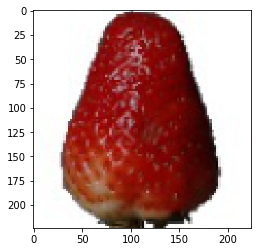

In [9]:
# 图片可视化
fig1 = plt.figure()
plt.imshow(img)

In [11]:
# 格式转化
img_array = img_to_array(img)
print(type(img_array), img_array.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [22]:
# 维度转化与数据预处理
img_preprocess = np.expand_dims(img_array, axis=0)
img_preprocess = preprocess_input(img_preprocess)
print(img_preprocess.shape)

(1, 224, 224, 3)


In [23]:
# VGG16提取特征
vgg16_model = VGG16(weights="imagenet", include_top=False)
features = vgg16_model.predict(img_preprocess)
print(features.shape, features)

(1, 7, 7, 512) [[[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]]

  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    4.9918442e+00 0.0000000e+00]

In [24]:
# 特征展开 flatten展开
features = features.reshape(1, 7*7*512)
print(features.shape)

(1, 25088)


In [38]:
# 批量图片的路径获取
folder = "/Users/mac/Desktop/chapter5_task2_data/training_data/"
files_name = os.listdir(folder)
print(files_name)
img_path = []  # 用于存储图片路径
for i in files_name:
    if os.path.splitext(i)[1] == ".jpg":
        img_path.append(folder + i)
print(img_path)

['gen_7_1870360.jpg', 'gen_2_6333987.jpg', 'labeled_1.jpg', 'gen_8_8431630.jpg', 'gen_2_1023382.jpg', 'gen_8_4852568.jpg', 'gen_4_2338348.jpg', '143_100.jpg', 'gen_0_7128569.jpg', 'gen_5_3768579.jpg', 'gen_0_6423858.jpg', 'gen_9_5053414.jpg', 'gen_5_415622.jpg', 'gen_0_9178035.jpg', 'gen_5_8460819.jpg', 'labeled_2.jpg', 'gen_11_3362049.jpg', 'gen_11_8716842.jpg', 'gen_4_4460546.jpg', 'gen_8_8132293.jpg', 'gen_4_9126283.jpg', 'gen_8_9413426.jpg', 'gen_6_5637383.jpg', 'gen_1_8511873.jpg', 'gen_1_6742095.jpg', 'gen_11_2162246.jpg', 'gen_6_8931707.jpg', 'gen_8_3833053.jpg', 'labeled_3.jpg', 'gen_8_3054311.jpg', 'gen_10_4348724.jpg', 'gen_0_3428440.jpg', 'labeled_7.jpg', 'gen_8_959338.jpg', 'gen_5_6376584.jpg', '.DS_Store', 'gen_11_8404633.jpg', 'gen_10_2024457.jpg', 'gen_9_8450517.jpg', 'gen_2_6670723.jpg', 'gen_8_2118182.jpg', 'gen_0_8851453.jpg', 'gen_10_5274861.jpg', 'labeled_6.jpg', 'gen_5_5074487.jpg', 'gen_0_6704901.jpg', 'gen_4_652183.jpg', 'gen_1_5692859.jpg', 'gen_1_1019678.jpg', 

In [39]:
# VGG16特征提取方法的定义
def modelProcess(img_path, model):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_preprocess = np.expand_dims(img_array, axis=0)
    img_preprocess = preprocess_input(img_preprocess)
    features = model.predict(img_preprocess)
    features = features.reshape(1, 7*7*512)
    return features

In [40]:
# 批量提取图片特征
features_train = np.zeros([len(img_path), 7*7*512])

In [41]:
for i in range(len(img_path)):
    features_temp = modelProcess(img_path[i], vgg16_model)
    features_train[i] = features_temp
    print("preprocess:", img_path[i])

preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_7_1870360.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_2_6333987.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/labeled_1.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_8_8431630.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_2_1023382.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_8_4852568.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_4_2338348.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/143_100.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_0_7128569.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_5_3768579.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_0_6423858.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_9_5053414.jpg
preprocess: /U

preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_10_1582568.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_5_2392022.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_4_602884.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_3_6199472.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_1_8285195.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/13.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/11.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_9_659856.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_3_1676477.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_11_7381654.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_10_54380.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_9_1014783.jpg
preprocess: /Users/mac/Desk

preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_7_2528019.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/7.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_1_9222904.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_9_7075262.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_3_9002293.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_0_2126226.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_3_7810586.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_2_851308.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_6_7965518.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_2_6347360.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_11_6820646.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/training_data/gen_2_7786435.jpg
preprocess: /Use

In [42]:
# 样本数量与特征数
print(features_train.shape)

(240, 25088)


In [43]:
# x赋值
x_train = features_train

In [44]:
# K-means模型进行聚类分析
vgg_kmeans = KMeans(n_clusters=2, max_iter=3000)
# 训练
vgg_kmeans.fit(x_train)

KMeans(max_iter=3000, n_clusters=2)

In [45]:
# 预测
y_predict_kmeans = vgg_kmeans.predict(x_train)
print(y_predict_kmeans)

[1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0
 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0
 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1
 1 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0
 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1
 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1
 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0]


In [46]:
# 预测结果分布统计
print(pd.value_counts(y_predict_kmeans))

1    123
0    117
dtype: int64


In [47]:
# 普通草莓class为1
normal_strawberry_class = 1

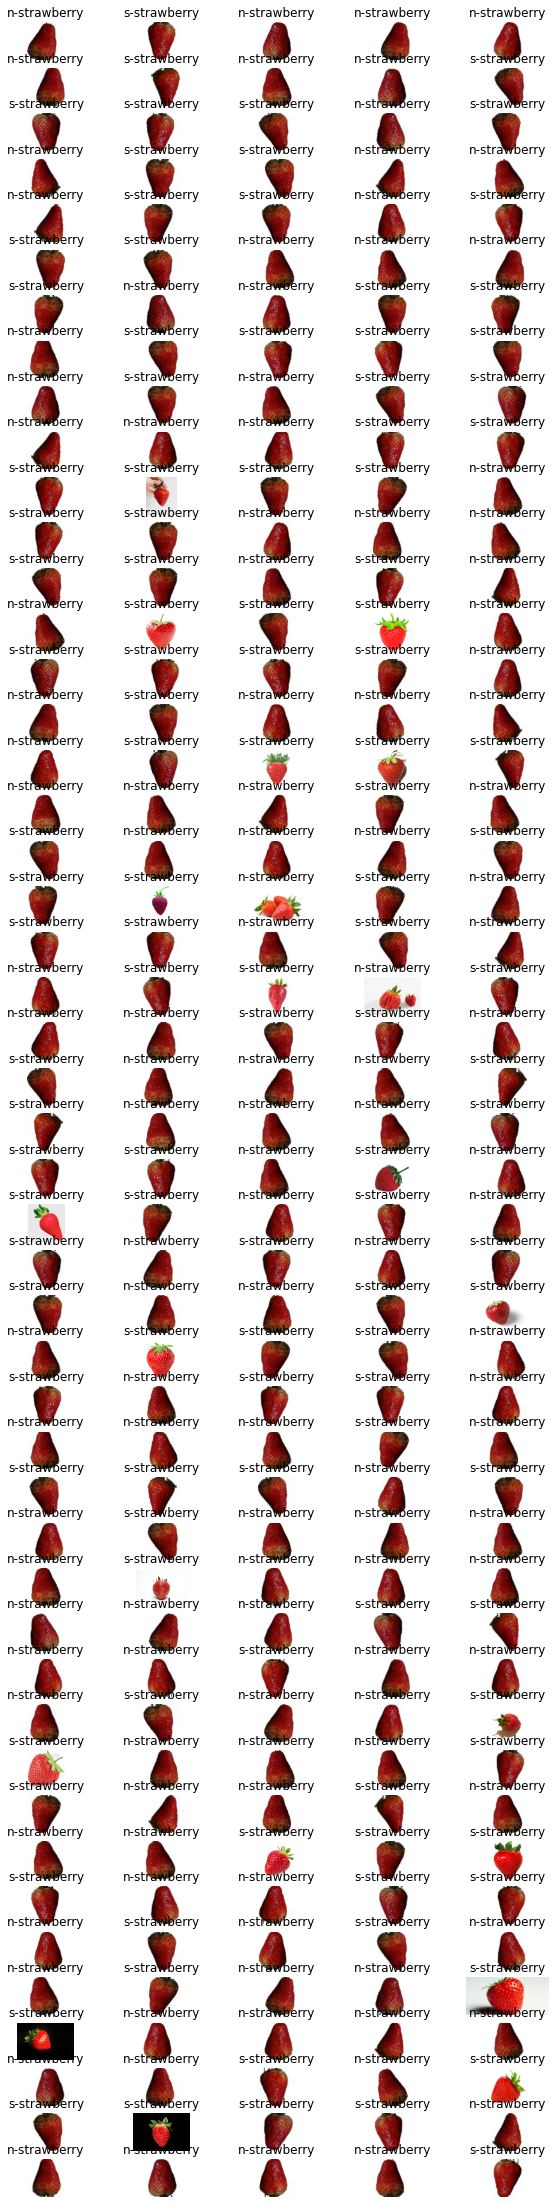

In [50]:
fig2 = plt.figure(figsize=(10, 40))
for i in range(48):
    for j in range(5):
        img = load_img(img_path[i*5 + j])
        plt.subplot(48,5,i*5+j+1)
        plt.title("n-strawberry" if y_predict_kmeans[i*5+j] == normal_strawberry_class else "s-strawberry")
        plt.imshow(img)
        plt.axis("off")

In [51]:
# 批量图片的路径获取
folder = "/Users/mac/Desktop/chapter5_task2_data/test_data/"
files_name = os.listdir(folder)
print(files_name)
img_path = []  # 用于存储图片路径
for i in files_name:
    if os.path.splitext(i)[1] == ".jpg":
        img_path.append(folder + i)
print(img_path)

['gen_0_8162928.jpg', 'gen_0_8646347.jpg', 'gen_1_9782.jpg', 'gen_0_7967246.jpg', '4.jpg', '5.jpg', 'gen_0_5413230.jpg', 'gen_0_5728814.jpg', '6.jpg', '2.jpg', '3.jpg', '1.jpg']
['/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_8162928.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_8646347.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_1_9782.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_7967246.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/4.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/5.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_5413230.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_5728814.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/6.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/2.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/3.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/1.jpg']


In [52]:
# 批量提取图片特征
features_test = np.zeros([len(img_path), 7*7*512])
for i in range(len(img_path)):
    features_temp = modelProcess(img_path[i], vgg16_model)
    features_test[i] = features_temp
    print("preprocess:", img_path[i])

preprocess: /Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_8162928.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_8646347.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/test_data/gen_1_9782.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_7967246.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/test_data/4.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/test_data/5.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_5413230.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_5728814.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/test_data/6.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/test_data/2.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/test_data/3.jpg
preprocess: /Users/mac/Desktop/chapter5_task2_data/test_data/1.jpg


In [53]:
x_test = features_test

In [55]:
# 测试数据预测
y_predict_kmeans_test = vgg_kmeans.predict(x_test)
print(y_predict_kmeans_test)

[0 0 0 0 0 0 0 1 0 0 1 0]


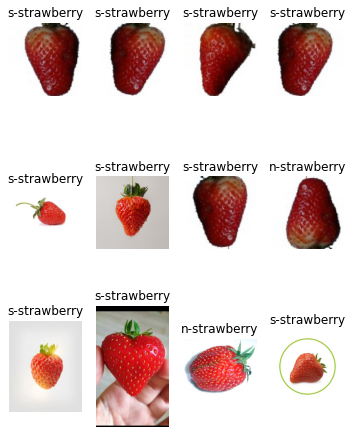

In [58]:
fig3 = plt.figure(figsize=(6, 8))
for i in range(3):
    for j in range(4):
        img = load_img(img_path[i*4 + j])
        plt.subplot(3,4,i*4+j+1)
        plt.title("n-strawberry" if y_predict_kmeans_test[i*4+j] == normal_strawberry_class else "s-strawberry")
        plt.imshow(img)
        plt.axis("off")

In [60]:
# meanshift模型替代kmeans模型
# 获取合适的meanshift半径
bw = estimate_bandwidth(x_train, n_samples=150)
print(bw)

1517.7588323598816


In [61]:
vgg_meanshift = MeanShift(bandwidth=bw)
# 模型训练
vgg_meanshift.fit(x_train)

MeanShift(bandwidth=1517.7588323598816)

In [68]:
# 预测
y_predict_meanshift = vgg_meanshift.predict(x_train)
print(y_predict_meanshift)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  9 12  0  0  0  0  0  0  0  0  0 13  1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0
  0  0  0  0  0  0  0  0  0  0 10  0 15  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 11  3  0  0  0  0  0  0  0  0  6  0  2  0  0  0  0  0  0  0  0]


In [69]:
pd.value_counts(y_predict_meanshift)

0     225
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
dtype: int64

In [70]:
# 普通草莓class为1
normal_strawberry_class = 0

In [72]:
# 批量图片的路径获取
folder = "/Users/mac/Desktop/chapter5_task2_data/training_data/"
files_name = os.listdir(folder)
print(files_name)
img_path = []  # 用于存储图片路径
for i in files_name:
    if os.path.splitext(i)[1] == ".jpg":
        img_path.append(folder + i)
print(img_path)

['gen_7_1870360.jpg', 'gen_2_6333987.jpg', 'labeled_1.jpg', 'gen_8_8431630.jpg', 'gen_2_1023382.jpg', 'gen_8_4852568.jpg', 'gen_4_2338348.jpg', '143_100.jpg', 'gen_0_7128569.jpg', 'gen_5_3768579.jpg', 'gen_0_6423858.jpg', 'gen_9_5053414.jpg', 'gen_5_415622.jpg', 'gen_0_9178035.jpg', 'gen_5_8460819.jpg', 'labeled_2.jpg', 'gen_11_3362049.jpg', 'gen_11_8716842.jpg', 'gen_4_4460546.jpg', 'gen_8_8132293.jpg', 'gen_4_9126283.jpg', 'gen_8_9413426.jpg', 'gen_6_5637383.jpg', 'gen_1_8511873.jpg', 'gen_1_6742095.jpg', 'gen_11_2162246.jpg', 'gen_6_8931707.jpg', 'gen_8_3833053.jpg', 'labeled_3.jpg', 'gen_8_3054311.jpg', 'gen_10_4348724.jpg', 'gen_0_3428440.jpg', 'labeled_7.jpg', 'gen_8_959338.jpg', 'gen_5_6376584.jpg', '.DS_Store', 'gen_11_8404633.jpg', 'gen_10_2024457.jpg', 'gen_9_8450517.jpg', 'gen_2_6670723.jpg', 'gen_8_2118182.jpg', 'gen_0_8851453.jpg', 'gen_10_5274861.jpg', 'labeled_6.jpg', 'gen_5_5074487.jpg', 'gen_0_6704901.jpg', 'gen_4_652183.jpg', 'gen_1_5692859.jpg', 'gen_1_1019678.jpg', 

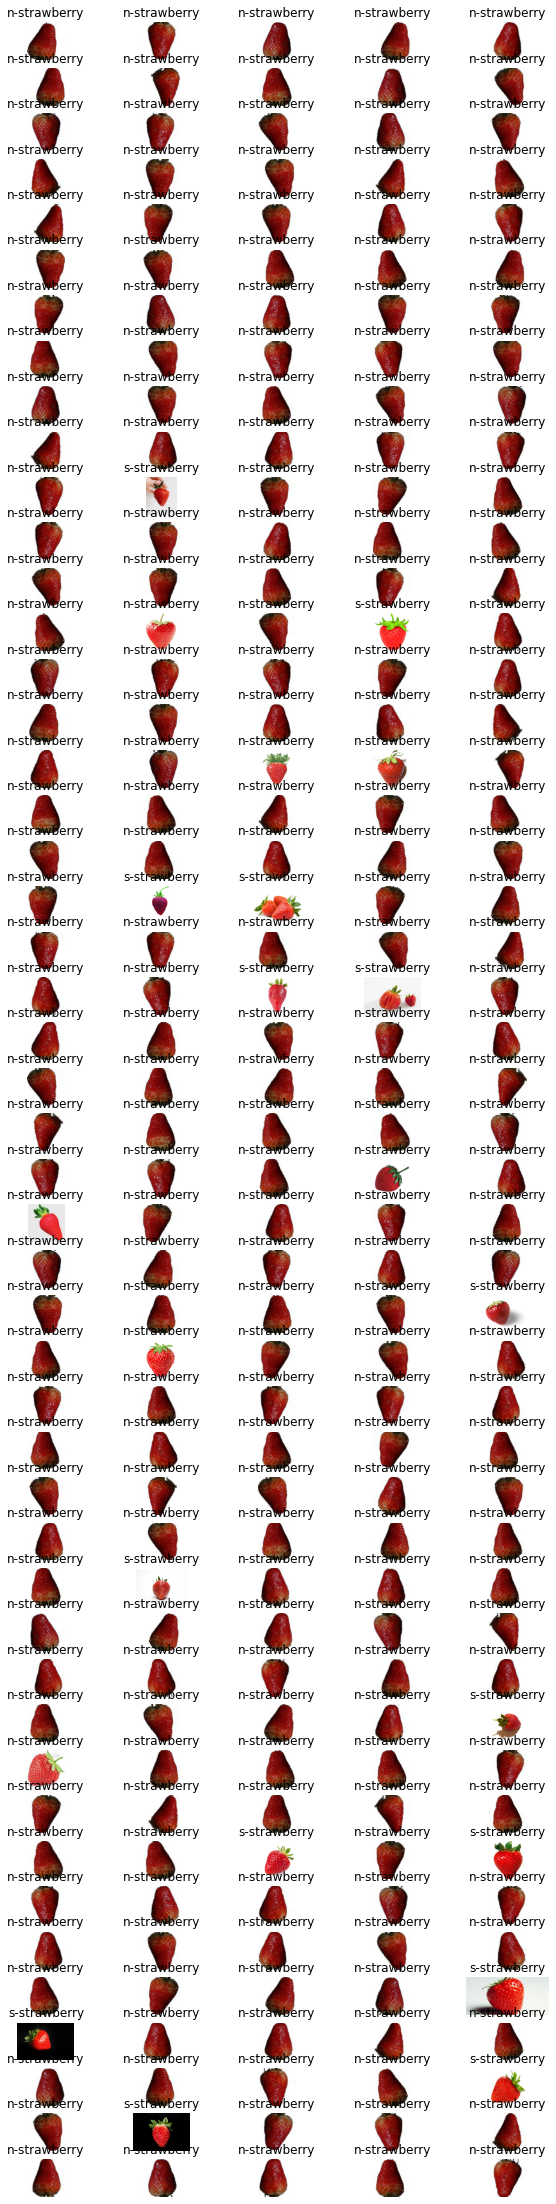

In [73]:
fig4 = plt.figure(figsize=(10, 40))
for i in range(48):
    for j in range(5):
        img = load_img(img_path[i*5 + j])
        plt.subplot(48,5,i*5+j+1)
        plt.title("n-strawberry" if y_predict_meanshift[i*5+j] == normal_strawberry_class else "s-strawberry")
        plt.imshow(img)
        plt.axis("off")

In [74]:
# 测试数据
folder = "/Users/mac/Desktop/chapter5_task2_data/test_data/"
files_name = os.listdir(folder)
print(files_name)
img_path = []  # 用于存储图片路径
for i in files_name:
    if os.path.splitext(i)[1] == ".jpg":
        img_path.append(folder + i)
print(img_path)

['gen_0_8162928.jpg', 'gen_0_8646347.jpg', 'gen_1_9782.jpg', 'gen_0_7967246.jpg', '4.jpg', '5.jpg', 'gen_0_5413230.jpg', 'gen_0_5728814.jpg', '6.jpg', '2.jpg', '3.jpg', '1.jpg']
['/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_8162928.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_8646347.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_1_9782.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_7967246.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/4.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/5.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_5413230.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_5728814.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/6.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/2.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/3.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/1.jpg']


In [75]:
# 测试数据预测
y_predict_meanshift_test = vgg_meanshift.predict(x_test)
print(y_predict_meanshift_test)

[0 0 0 0 8 4 0 0 5 0 0 0]


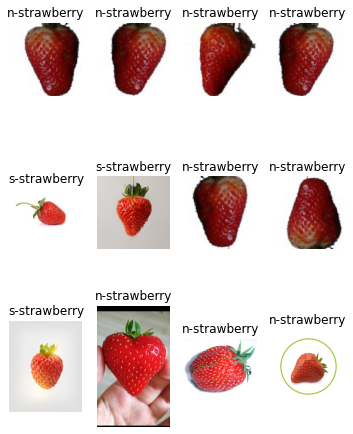

In [76]:
fig5 = plt.figure(figsize=(6, 8))
for i in range(3):
    for j in range(4):
        img = load_img(img_path[i*4 + j])
        plt.subplot(3,4,i*4+j+1)
        plt.title("n-strawberry" if y_predict_meanshift_test[i*4+j] == normal_strawberry_class else "s-strawberry")
        plt.imshow(img)
        plt.axis("off")

In [79]:
# PCA主成分分析
standards = StandardScaler()
x_train_standard = standards.fit_transform(x_train)
pca = PCA(n_components=200)
x_pca = pca.fit_transform(x_train_standard)

In [80]:
# 维度确认
print(x_train.shape, x_pca.shape)

(240, 25088) (240, 200)


In [81]:
# 计算降维后的方差比例
var_ratio = pca.explained_variance_ratio_
print(np.sum(var_ratio))

0.9744927397543954


In [82]:
# 创建第二个ms模型
# 获取ms的半径
bw2 = estimate_bandwidth(x_pca, n_samples=150)
print(bw2)

167.8542861659749


In [83]:
vgg_pca_ms = MeanShift(bandwidth=bw2)
vgg_pca_ms.fit(x_pca)

MeanShift(bandwidth=167.8542861659749)

In [84]:
# 模型预测
y_predict_pca_ms = vgg_pca_ms.predict(x_pca)
print(y_predict_pca_ms)

[ 4  0  0  0  0  0 27  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
  0 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 24  0  0  0  0  0  0  2  0  0  0  0  0  0  0 19  0 17  0  0  0
  0  0  0  0  0  0  0  3  0  0 16 21  0  0  0  0  0  0  0  0  0  0  0  0
 13  5  0  0  0  0  0  0  0  0  0 26  8  0  0  0  0  0  0  0  0  0  0 25
  0  0  0  0  0  0  0  0  9  0 14 23  0  0  0  0  0  0  0  0  0  0  0  0
 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  6  0
  0  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 18 10  0  0  0  0  0  0  0  0  7  0 20  0  0  0  0  0  0  0  0]


In [85]:
print(pd.value_counts(y_predict_pca_ms))

0     212
15      1
27      1
26      1
25      1
24      1
23      1
22      1
21      1
20      1
19      1
18      1
17      1
16      1
14      1
1       1
13      1
12      1
11      1
10      1
9       1
8       1
7       1
6       1
5       1
4       1
3       1
2       1
28      1
dtype: int64


In [86]:
# 批量图片的路径获取
folder = "/Users/mac/Desktop/chapter5_task2_data/training_data/"
files_name = os.listdir(folder)
print(files_name)
img_path = []  # 用于存储图片路径
for i in files_name:
    if os.path.splitext(i)[1] == ".jpg":
        img_path.append(folder + i)
print(img_path)

['gen_7_1870360.jpg', 'gen_2_6333987.jpg', 'labeled_1.jpg', 'gen_8_8431630.jpg', 'gen_2_1023382.jpg', 'gen_8_4852568.jpg', 'gen_4_2338348.jpg', '143_100.jpg', 'gen_0_7128569.jpg', 'gen_5_3768579.jpg', 'gen_0_6423858.jpg', 'gen_9_5053414.jpg', 'gen_5_415622.jpg', 'gen_0_9178035.jpg', 'gen_5_8460819.jpg', 'labeled_2.jpg', 'gen_11_3362049.jpg', 'gen_11_8716842.jpg', 'gen_4_4460546.jpg', 'gen_8_8132293.jpg', 'gen_4_9126283.jpg', 'gen_8_9413426.jpg', 'gen_6_5637383.jpg', 'gen_1_8511873.jpg', 'gen_1_6742095.jpg', 'gen_11_2162246.jpg', 'gen_6_8931707.jpg', 'gen_8_3833053.jpg', 'labeled_3.jpg', 'gen_8_3054311.jpg', 'gen_10_4348724.jpg', 'gen_0_3428440.jpg', 'labeled_7.jpg', 'gen_8_959338.jpg', 'gen_5_6376584.jpg', '.DS_Store', 'gen_11_8404633.jpg', 'gen_10_2024457.jpg', 'gen_9_8450517.jpg', 'gen_2_6670723.jpg', 'gen_8_2118182.jpg', 'gen_0_8851453.jpg', 'gen_10_5274861.jpg', 'labeled_6.jpg', 'gen_5_5074487.jpg', 'gen_0_6704901.jpg', 'gen_4_652183.jpg', 'gen_1_5692859.jpg', 'gen_1_1019678.jpg', 

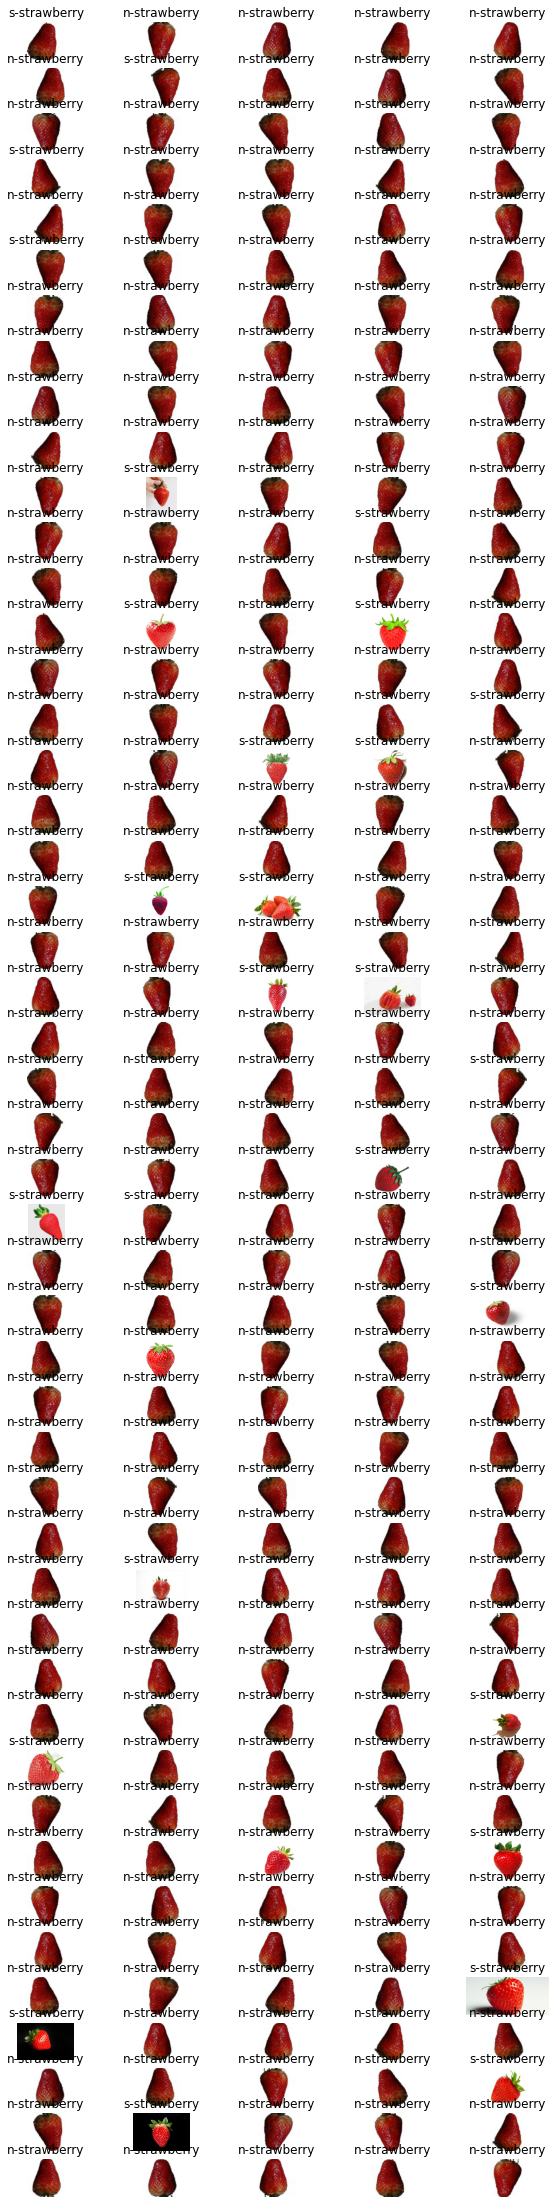

In [87]:
fig6 = plt.figure(figsize=(10, 40))
for i in range(48):
    for j in range(5):
        img = load_img(img_path[i*5 + j])
        plt.subplot(48,5,i*5+j+1)
        plt.title("n-strawberry" if y_predict_pca_ms[i*5+j] == normal_strawberry_class else "s-strawberry")
        plt.imshow(img)
        plt.axis("off")

In [88]:
# 测试数据
folder = "/Users/mac/Desktop/chapter5_task2_data/test_data/"
files_name = os.listdir(folder)
print(files_name)
img_path = []  # 用于存储图片路径
for i in files_name:
    if os.path.splitext(i)[1] == ".jpg":
        img_path.append(folder + i)
print(img_path)

['gen_0_8162928.jpg', 'gen_0_8646347.jpg', 'gen_1_9782.jpg', 'gen_0_7967246.jpg', '4.jpg', '5.jpg', 'gen_0_5413230.jpg', 'gen_0_5728814.jpg', '6.jpg', '2.jpg', '3.jpg', '1.jpg']
['/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_8162928.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_8646347.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_1_9782.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_7967246.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/4.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/5.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_5413230.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/gen_0_5728814.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/6.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/2.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/3.jpg', '/Users/mac/Desktop/chapter5_task2_data/test_data/1.jpg']


In [90]:
# 测试数据预测
x_test_normal = standards.transform(x_test)
x_test_pca = pca.transform(x_test_normal)
y_predict_pca_ms_test = vgg_pca_ms.predict(x_test_pca)
print(y_predict_pca_ms_test)

[ 0  0 25  0  0  0  0  0  0  6  0  0]


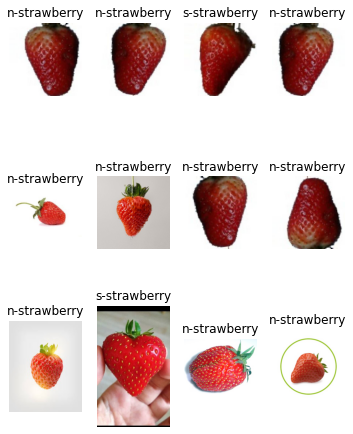

In [91]:
fig7 = plt.figure(figsize=(6, 8))
for i in range(3):
    for j in range(4):
        img = load_img(img_path[i*4 + j])
        plt.subplot(3,4,i*4+j+1)
        plt.title("n-strawberry" if y_predict_pca_ms_test[i*4+j] == normal_strawberry_class else "s-strawberry")
        plt.imshow(img)
        plt.axis("off")